In [8]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from umap import UMAP
from scipy.sparse import load_npz
import logging

# إعداد اللوجينغ
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# إعداد المتغيرات
dataset = "antique"  # antique أو trec_tot
n_clusters = 3
sample_size = 3000
n_neighbors = 30
min_dist = 0.1
project_root = os.getcwd()

# المسارات
base_offline_path = os.path.join(project_root, "offline_indexing_service", "data", dataset)
base_data_path = os.path.join(project_root, "data", dataset)

vectorizer_path = os.path.join(base_offline_path, "tfidf_vectorizer.pkl")
tfidf_matrix_path = os.path.join(base_offline_path, "tfidf_docs_matrix.npz")
doc_file = os.path.join(base_data_path, f"{dataset}_docs_clean.csv")


In [9]:
def load_data(vectorizer_path, tfidf_matrix_path, doc_file):
    logger.info("📦 تحميل النموذج والمصفوفة والوثائق...")
    vectorizer = joblib.load(vectorizer_path)
    tfidf_matrix = load_npz(tfidf_matrix_path)
    doc_ids = pd.read_csv(doc_file)["doc_id"].astype(str).tolist()
    logger.info(f"✅ عدد الوثائق: {len(doc_ids)}, أبعاد المصفوفة: {tfidf_matrix.shape}")
    return vectorizer, tfidf_matrix, doc_ids

vectorizer, tfidf_matrix, doc_ids = load_data(vectorizer_path, tfidf_matrix_path, doc_file)


INFO:__main__:📦 تحميل النموذج والمصفوفة والوثائق...
INFO:__main__:✅ عدد الوثائق: 27422, أبعاد المصفوفة: (27422, 35106)


In [10]:
def reduce_dimensions(tfidf_matrix, sample_size=3000, n_neighbors=30, min_dist=0.1):
    sample_size = min(sample_size, tfidf_matrix.shape[0])
    sample_indices = np.random.choice(tfidf_matrix.shape[0], sample_size, replace=False)
    sample_matrix = tfidf_matrix[sample_indices]

    umap = UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, metric='cosine', random_state=42)
    reduced_data = umap.fit_transform(sample_matrix)
    return reduced_data, sample_indices

reduced_data, sample_indices = reduce_dimensions(tfidf_matrix, sample_size, n_neighbors, min_dist)


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [11]:
def perform_clustering(tfidf_matrix, n_clusters=5):
    logger.info("🔄 تنفيذ MiniBatchKMeans...")
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=512, random_state=42)
    labels = kmeans.fit_predict(tfidf_matrix)
    return labels, kmeans

full_labels, kmeans = perform_clustering(tfidf_matrix, n_clusters)


INFO:__main__:🔄 تنفيذ MiniBatchKMeans...


In [12]:
def extract_top_terms(vectorizer, tfidf_matrix, labels, n_clusters=5, top_n=10):
    logger.info("📌 استخراج المصطلحات العليا لكل عنقود...")
    terms = vectorizer.get_feature_names_out()
    cluster_terms = {}

    for i in range(n_clusters):
        indices = np.where(labels == i)[0]
        cluster_matrix = tfidf_matrix[indices].mean(axis=0).A1
        top_indices = cluster_matrix.argsort()[::-1][:top_n]
        top_terms = [terms[j] for j in top_indices]
        cluster_terms[i] = top_terms
        logger.info(f"Cluster {i}: {', '.join(top_terms)}")

    return cluster_terms

top_terms = extract_top_terms(vectorizer, tfidf_matrix, full_labels, n_clusters)


INFO:__main__:📌 استخراج المصطلحات العليا لكل عنقود...
INFO:__main__:Cluster 0: get, go, like, one, good, use, would, make, time, peopl
INFO:__main__:Cluster 1: think, work, get, dont, peopl, like, would, tri, go, make
INFO:__main__:Cluster 2: dont, know, god, u, peopl, like, want, believ, say, would


INFO:__main__:📊 رسم المخطط...
C:\Users\ASUS\AppData\Local\Temp\ipykernel_33188\193245754.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_33188\193245754.py:15: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_33188\193245754.py:16: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


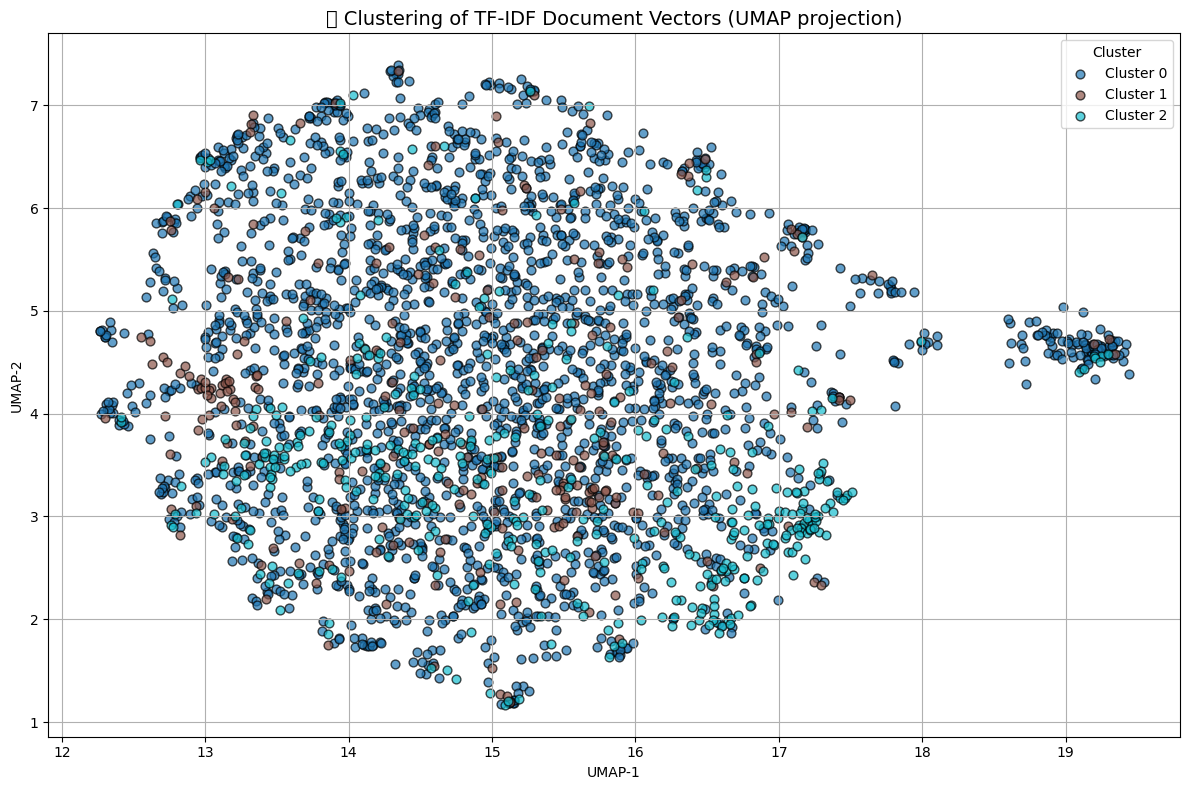

INFO:__main__:✅ تم حفظ المخطط في: C:\Users\ASUS\Documents\ir_project2\offline_indexing_service\data\antique\clusters_plot.png


In [13]:
def plot_clusters(reduced_data, sample_labels, n_clusters, save_path):
    logger.info("📊 رسم المخطط...")
    plt.figure(figsize=(12, 8))
    colors = plt.cm.get_cmap('tab10', n_clusters)

    for i in range(n_clusters):
        points = reduced_data[sample_labels == i]
        plt.scatter(points[:, 0], points[:, 1], label=f"Cluster {i}", s=40, alpha=0.7, color=colors(i), edgecolors='k')

    plt.title("🧠 Clustering of TF-IDF Document Vectors (UMAP projection)", fontsize=14)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    logger.info(f"✅ تم حفظ المخطط في: {save_path}")

sample_labels = full_labels[sample_indices]
plot_path = os.path.join(base_offline_path, "clusters_plot.png")
plot_clusters(reduced_data, sample_labels, n_clusters, plot_path)


In [14]:
logger.info("📊 تقييم جودة التجميع...")

sil = silhouette_score(tfidf_matrix, full_labels)
db = davies_bouldin_score(tfidf_matrix.toarray(), full_labels)
ch = calinski_harabasz_score(tfidf_matrix.toarray(), full_labels)

print(f"Silhouette Score: {sil:.3f}")
print(f"Davies-Bouldin Score: {db:.3f}")
print(f"Calinski-Harabasz Score: {ch:.3f}")


INFO:__main__:📊 تقييم جودة التجميع...


Silhouette Score: 0.001
Davies-Bouldin Score: 13.081
Calinski-Harabasz Score: 65.684


📦 تحميل بيانات التمثيل (Embeddings)...
✅ شكل بيانات embeddings: (27422, 384)

🔷 تجربة UMAP مع n_neighbors=15


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



--- عدد العناقيد: 3 ---


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


Silhouette Score: 0.0109
Davies-Bouldin Score: 5.9435
Calinski-Harabasz Score: 481.8276


C:\Users\ASUS\AppData\Local\Temp\ipykernel_33188\1736366571.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


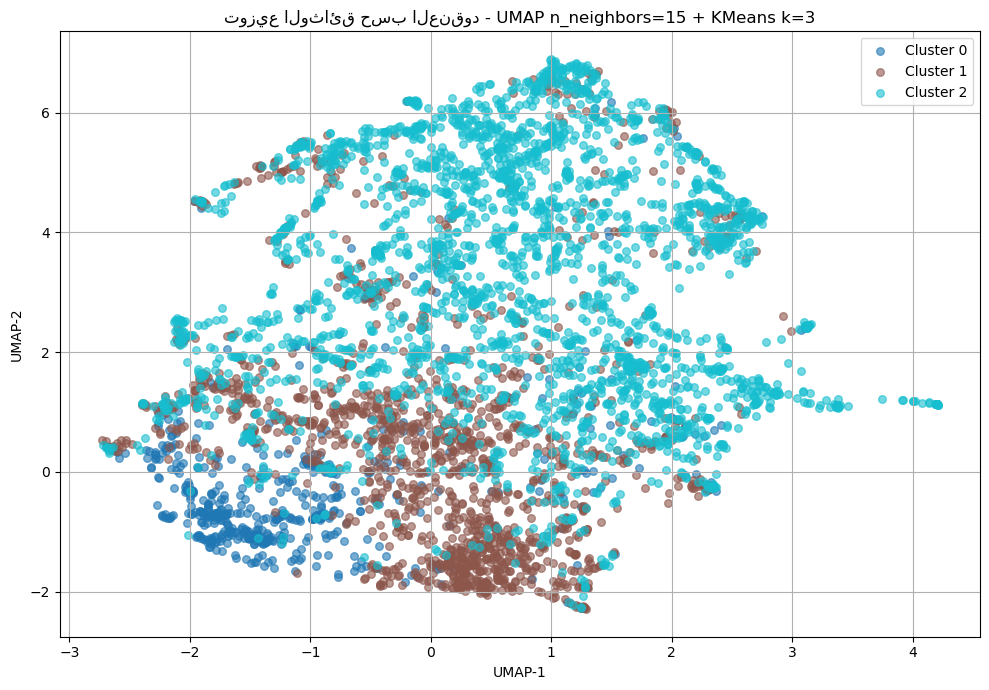


--- عدد العناقيد: 5 ---


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


Silhouette Score: 0.0167
Davies-Bouldin Score: 5.5875
Calinski-Harabasz Score: 442.9175


C:\Users\ASUS\AppData\Local\Temp\ipykernel_33188\1736366571.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


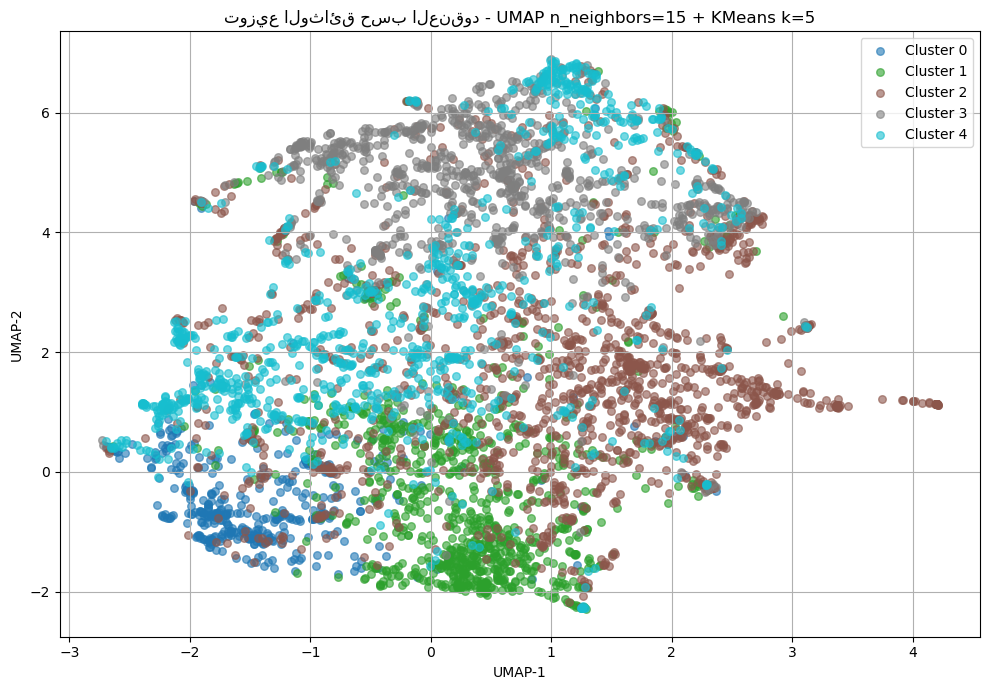


--- عدد العناقيد: 8 ---


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


Silhouette Score: 0.0181
Davies-Bouldin Score: 5.2856
Calinski-Harabasz Score: 352.8393


C:\Users\ASUS\AppData\Local\Temp\ipykernel_33188\1736366571.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


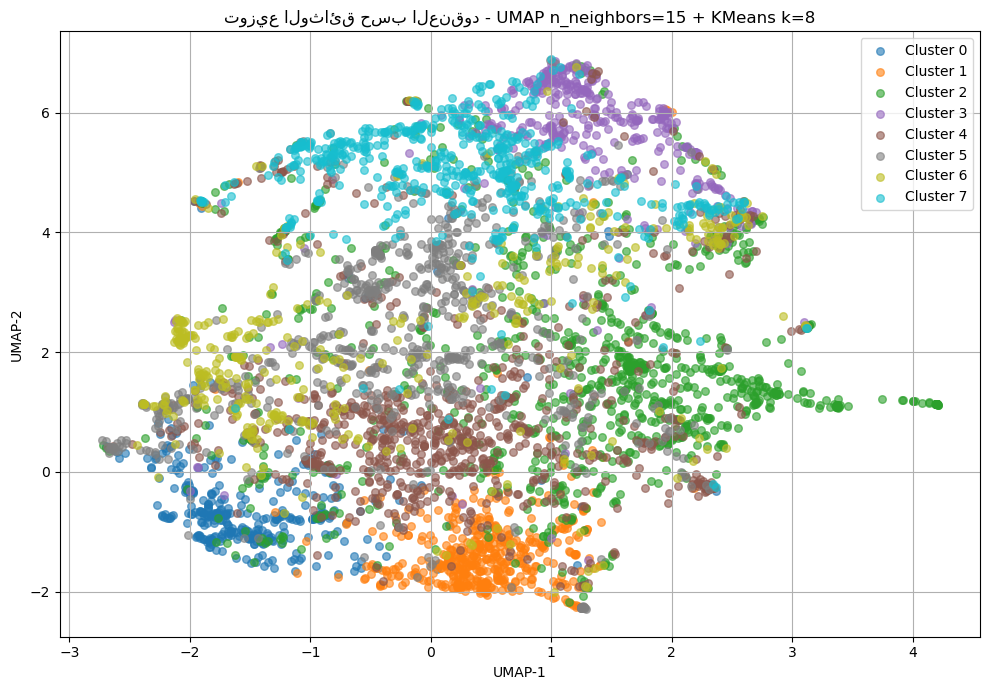


🔷 تجربة UMAP مع n_neighbors=30


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



--- عدد العناقيد: 3 ---


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


Silhouette Score: 0.0109
Davies-Bouldin Score: 5.9435
Calinski-Harabasz Score: 481.8276


C:\Users\ASUS\AppData\Local\Temp\ipykernel_33188\1736366571.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


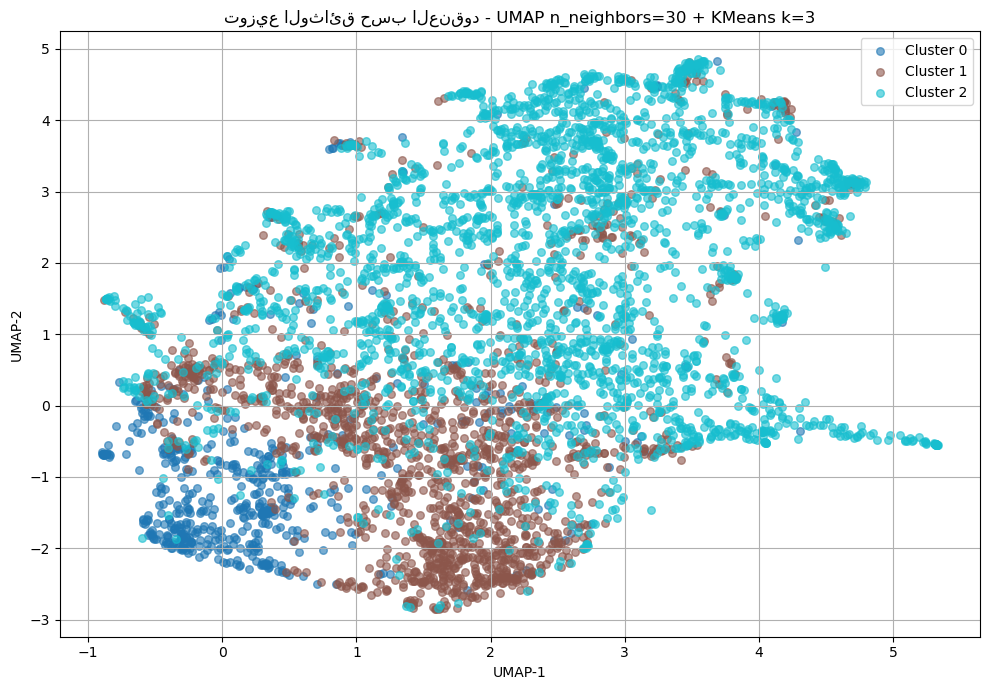


--- عدد العناقيد: 5 ---


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


Silhouette Score: 0.0167
Davies-Bouldin Score: 5.5875
Calinski-Harabasz Score: 442.9175


C:\Users\ASUS\AppData\Local\Temp\ipykernel_33188\1736366571.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


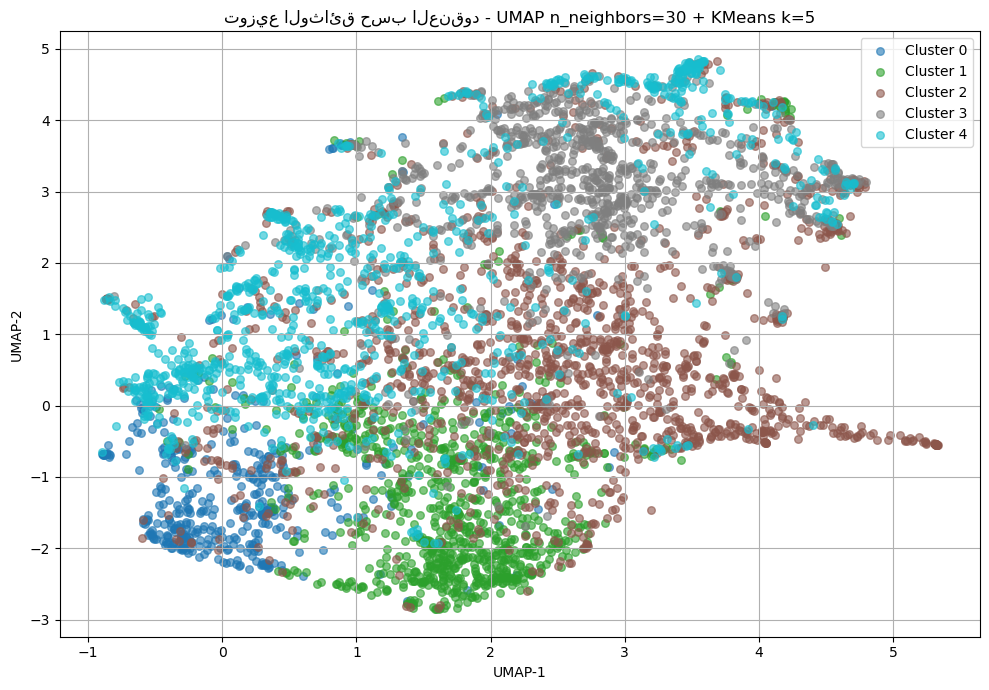


--- عدد العناقيد: 8 ---


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


Silhouette Score: 0.0181
Davies-Bouldin Score: 5.2856
Calinski-Harabasz Score: 352.8393


C:\Users\ASUS\AppData\Local\Temp\ipykernel_33188\1736366571.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


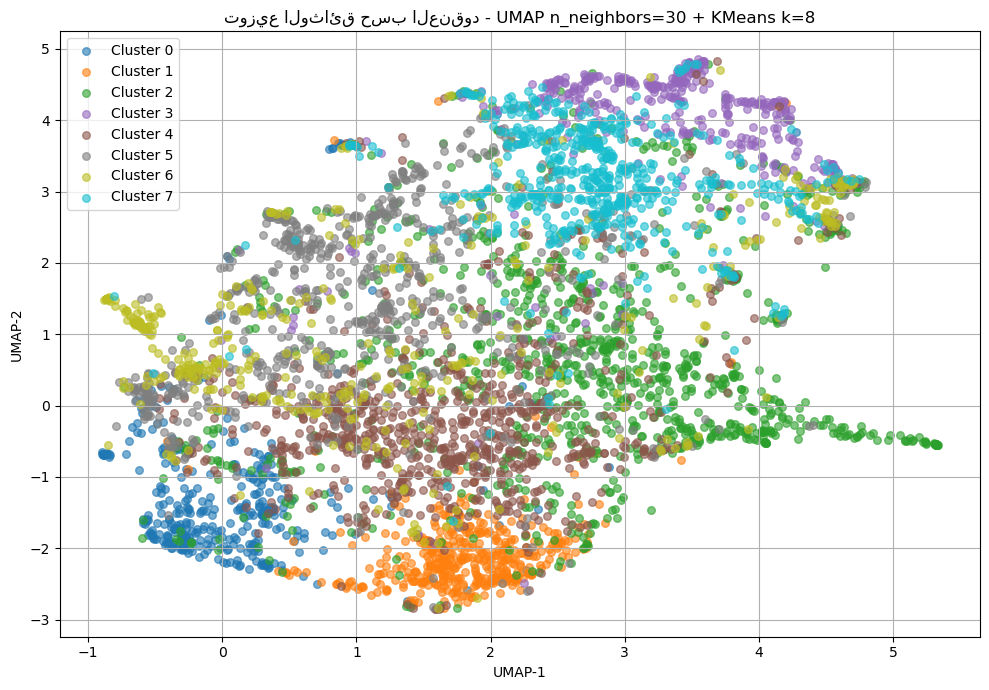


🔷 تجربة UMAP مع n_neighbors=50


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



--- عدد العناقيد: 3 ---


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


Silhouette Score: 0.0109
Davies-Bouldin Score: 5.9435
Calinski-Harabasz Score: 481.8276


C:\Users\ASUS\AppData\Local\Temp\ipykernel_33188\1736366571.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


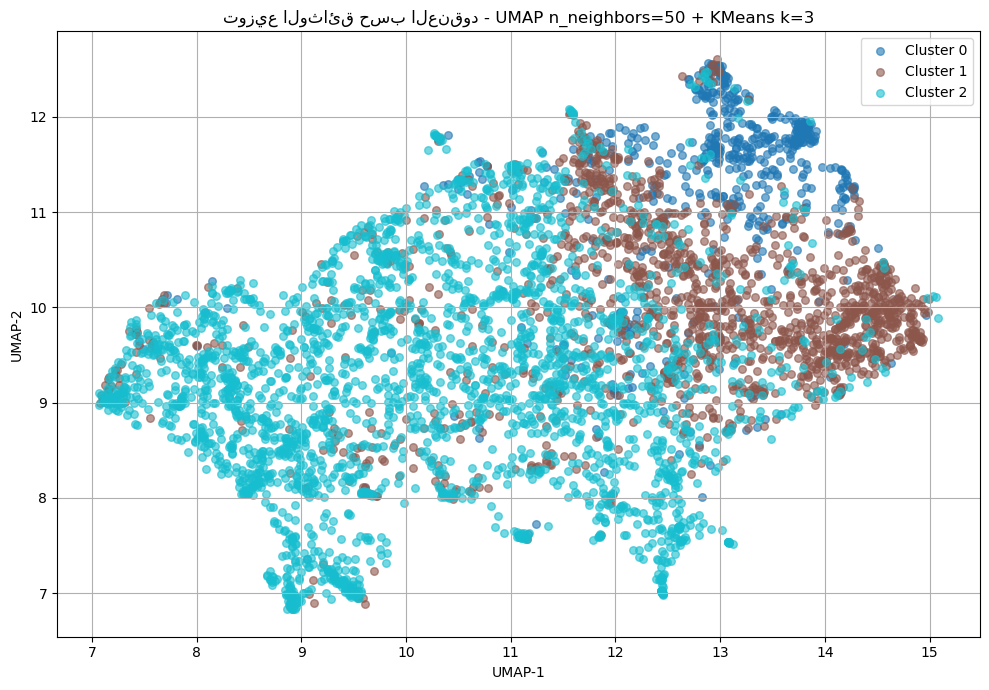


--- عدد العناقيد: 5 ---


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


Silhouette Score: 0.0167
Davies-Bouldin Score: 5.5875
Calinski-Harabasz Score: 442.9175


C:\Users\ASUS\AppData\Local\Temp\ipykernel_33188\1736366571.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


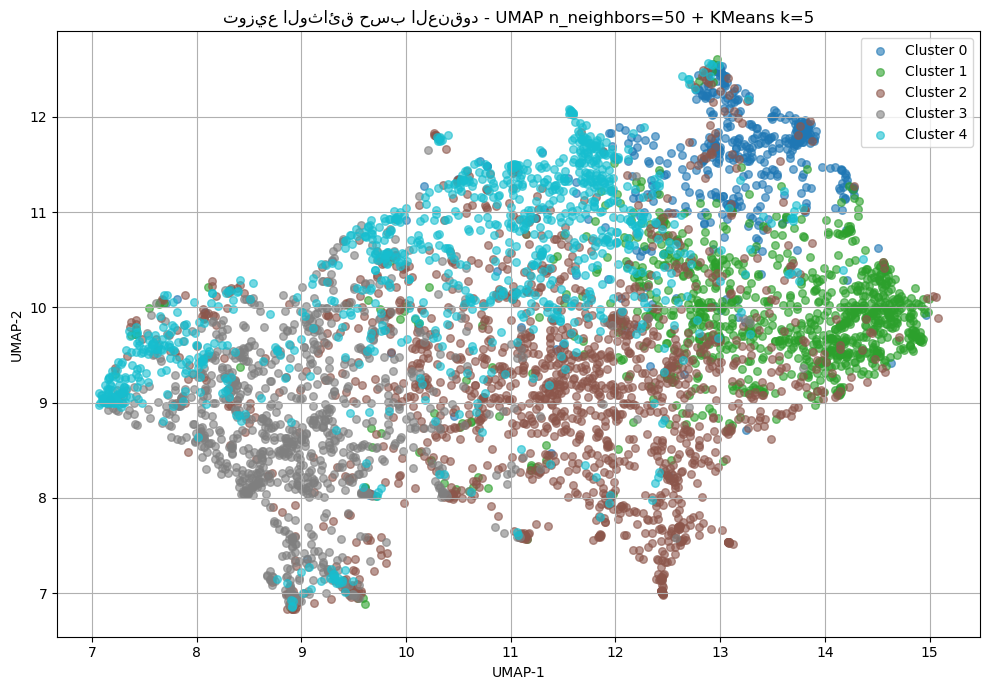


--- عدد العناقيد: 8 ---


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


Silhouette Score: 0.0181
Davies-Bouldin Score: 5.2856
Calinski-Harabasz Score: 352.8393


C:\Users\ASUS\AppData\Local\Temp\ipykernel_33188\1736366571.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


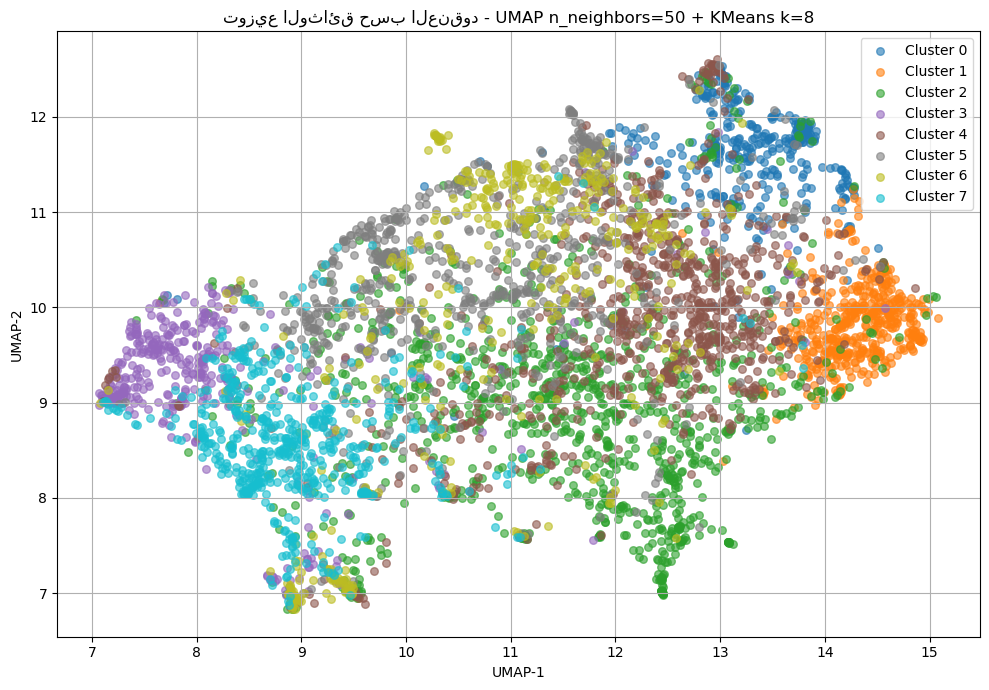

In [15]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from umap import UMAP

# === الإعدادات ===
dataset = "antique"  # "antique" أو "trec_tot"
project_root = os.getcwd()

# مسارات البيانات
base_offline_indexing_path = os.path.join(project_root, "offline_indexing_service", "data", dataset)

# نفترض أن هناك ملف embeddings dense numpy (مثل: embeddings.npy)
embeddings_path = os.path.join(base_offline_indexing_path, "doc_embeddings.npy")

base_data_path = os.path.join(project_root, "data", dataset)
if dataset == "trec_tot":
    doc_file = os.path.join(base_data_path, "trec_tot_docs_clean.csv")
elif dataset == "antique":
    doc_file = os.path.join(base_data_path, "antique_docs_clean.csv")
else:
    raise Exception("Dataset not recognized")

# تحميل البيانات
print("📦 تحميل بيانات التمثيل (Embeddings)...")
embeddings = np.load(embeddings_path)
doc_ids = pd.read_csv(doc_file)["doc_id"].astype(str).tolist()

print(f"✅ شكل بيانات embeddings: {embeddings.shape}")

# === إعدادات للتجربة ===
cluster_options = [3, 5, 8, 10, 12, 15, 20]

umap_neighbors_options = [15, 30, 50]

# دالة الرسم
def plot_clusters(reduced_data, labels, n_clusters, title_suffix):
    plt.figure(figsize=(10, 7))
    colors = plt.cm.get_cmap('tab10', n_clusters)
    for i in range(n_clusters):
        cluster_points = reduced_data[labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                    label=f"Cluster {i}", s=30, alpha=0.6, color=colors(i))
    plt.title(f"توزيع الوثائق حسب العنقود - {title_suffix}")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === تجربة التجميع بعد تقليل الأبعاد بواسطة UMAP ===
for n_neighbors in umap_neighbors_options:
    print(f"\n🔷 تجربة UMAP مع n_neighbors={n_neighbors}")
    
    sample_size = min(5000, embeddings.shape[0])
    sample_indices = np.random.choice(embeddings.shape[0], sample_size, replace=False)
    sample_embeddings = embeddings[sample_indices]
    
    umap = UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=0.0, metric='cosine', random_state=42)
    reduced_sample = umap.fit_transform(sample_embeddings)
    
    for n_clusters in cluster_options:
        print(f"\n--- عدد العناقيد: {n_clusters} ---")
        kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=512, random_state=42)
        full_labels = kmeans.fit_predict(embeddings)
        
        sil_score = silhouette_score(embeddings, full_labels)
        db_score = davies_bouldin_score(embeddings, full_labels)
        ch_score = calinski_harabasz_score(embeddings, full_labels)
        
        print(f"Silhouette Score: {sil_score:.4f}")
        print(f"Davies-Bouldin Score: {db_score:.4f}")
        print(f"Calinski-Harabasz Score: {ch_score:.4f}")
        
        # لا توجد كلمات هنا لأن embeddings لا تحوي كلمات، يمكن حفظ النتائج فقط
        
        sample_labels = full_labels[sample_indices]
        plot_clusters(reduced_sample, sample_labels, n_clusters, f"UMAP n_neighbors={n_neighbors} + KMeans k={n_clusters}")

# === حفظ نتائج الكلاستر لكل الوثائق ===
# import pandas as pd
# results_path = os.path.join(base_offline_indexing_path, "embedding_clusters.csv")
# docs_df = pd.DataFrame({
#     "doc_id": doc_ids,
#     "cluster_label": full_labels
# })
# docs_df.to_csv(results_path, index=False)
# print(f"\n📁 تم حفظ نتائج التجميع في: {results_path}")
